In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy import stats

In [ ]:
# Loading Data
sp500_ticker = "^GSPC"
start_date = "2021-02-01"
end_date = "2024-02-29"
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date,auto_adjust=False)['Adj Close']

ig_data = pd.read_csv('IG.csv', index_col='Date', parse_dates=True)
hy_data = pd.read_csv('HY.csv', index_col='Date', parse_dates=True)

sp500_data.rename(columns={'^GSPC': 'SP500_Adj_Close'}, inplace=True)
combined_data = sp500_data.join(ig_data, how='left').join(hy_data, how='left', rsuffix='_HY')

combined_data['SP500_Daily_Return'] = combined_data['SP500_Adj_Close'].pct_change()
combined_data['IG_Daily_Return'] = combined_data['S&P 500 Investment Grade Corporate Bond Index'].pct_change()
combined_data['HY_Daily_Return'] = combined_data['S&P U.S. Dollar Global High Yield Corporate Bond Index'].pct_change()

combined_data.fillna(method='ffill', inplace=True) # forward fill the missing values
combined_data.fillna(method='bfill', inplace=True) # back fill any remaining missing values

combined_data.head()

[*********************100%***********************]  1 of 1 completed
/var/folders/lg/z6wm11r5617_11hqzqgtr_vw0000gn/T/ipykernel_14838/1270884387.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ig_data = pd.read_csv('/Users/liuyuxuan/Downloads/xgboost-for-bonds/IG.csv', index_col='Date', parse_dates=True)
/var/folders/lg/z6wm11r5617_11hqzqgtr_vw0000gn/T/ipykernel_14838/1270884387.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hy_data = pd.read_csv('/Users/liuyuxuan/Downloads/xgboost-for-bonds/HY.csv', index_col='Date', parse_dates=True)


,SP500_Adj_Close,S&P 500 Investment Grade Corporate Bond Index,S&P U.S. Dollar Global High Yield Corporate Bond Index,SP500_Daily_Return,IG_Daily_Return,HY_Daily_Return
Date,,,,,,
2021-02-01,3773.860107,496.69,759.08,0.013898,-0.002195,0.001515
2021-02-02,3826.310059,495.60,760.23,0.013898,-0.002195,0.001515
2021-02-03,3830.169922,494.35,760.94,0.001009,-0.002522,0.000934
2021-02-04,3871.739990,494.35,762.16,0.010853,0.000000,0.001603
2021-02-05,3886.830078,493.49,762.96,0.003897,-0.001740,0.001050


## EDA

In [ ]:
print(combined_data[['SP500_Daily_Return', 'IG_Daily_Return', 'HY_Daily_Return']].describe())

       SP500_Daily_Return  IG_Daily_Return  HY_Daily_Return
count          774.000000       774.000000       774.000000
mean             0.000459        -0.000125         0.000033
std              0.010939         0.004481         0.002916
min             -0.043237        -0.019090        -0.021543
25%             -0.005671        -0.002836        -0.001374
50%              0.000502        -0.000160         0.000128
75%              0.006875         0.002715         0.001250
max              0.055434         0.018410         0.012203


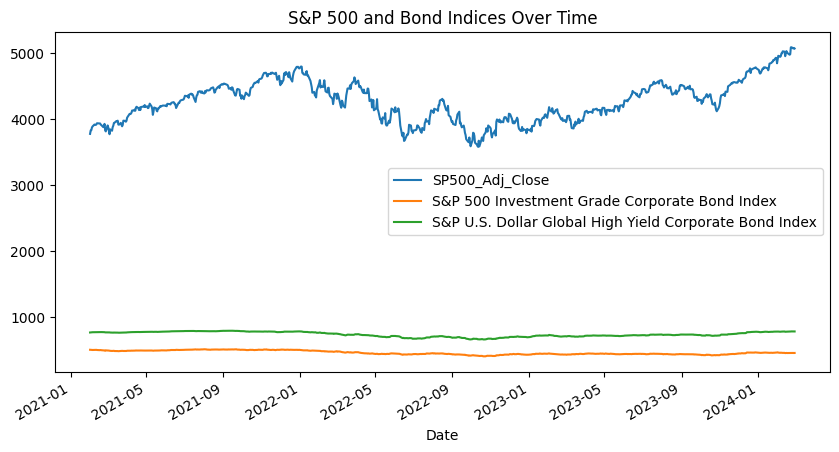

In [ ]:
combined_data[['SP500_Adj_Close', 'S&P 500 Investment Grade Corporate Bond Index', 'S&P U.S. Dollar Global High Yield Corporate Bond Index']].plot(figsize=(10, 5))
plt.title('S&P 500 and Bond Indices Over Time')
plt.show()

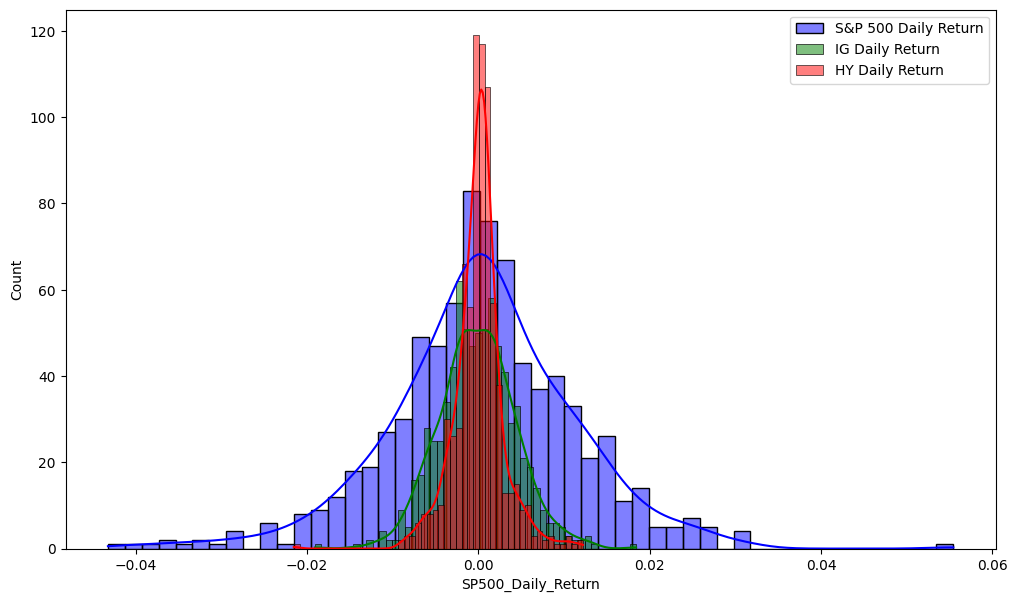

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(combined_data['SP500_Daily_Return'], bins=50, kde=True, color='blue', label='S&P 500 Daily Return')
sns.histplot(combined_data['IG_Daily_Return'], bins=50, kde=True, color='green', label='IG Daily Return')
sns.histplot(combined_data['HY_Daily_Return'], bins=50, kde=True, color='red', label='HY Daily Return')
plt.legend()
plt.show()

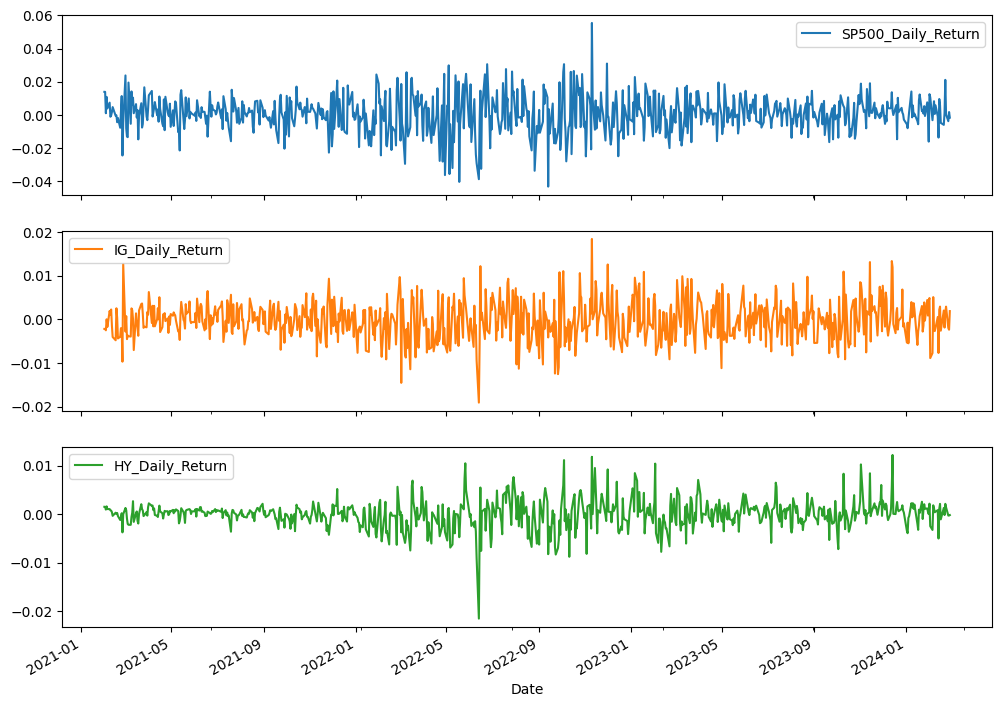

In [ ]:
combined_data[['SP500_Daily_Return', 'IG_Daily_Return', 'HY_Daily_Return']].plot(subplots=True, figsize=(12, 9))
plt.show()

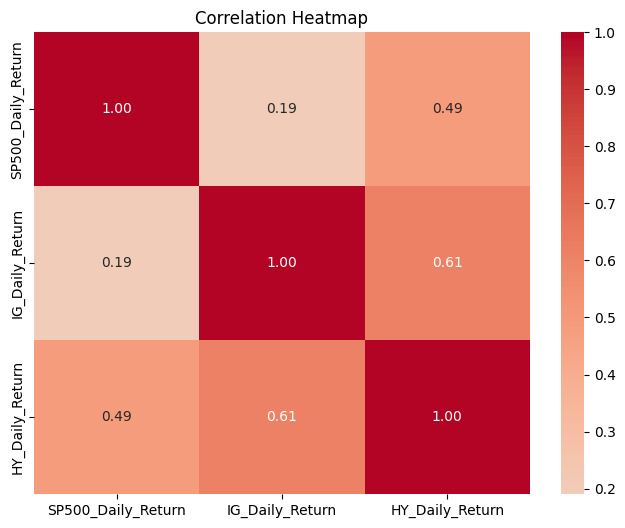

In [ ]:
correlation_matrix = combined_data[['SP500_Daily_Return', 'IG_Daily_Return', 'HY_Daily_Return']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Feature Engineering

In [ ]:
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
combined_data['SP500_Volume'] = sp500['Volume']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Creating 1X0, 4X0, 12X0 momentum factors
combined_data['Recent_5D_Avg'] = combined_data['SP500_Adj_Close'].rolling(window=5).mean() # the average of the most recent 1-week's (5 days) returns
# 1x0
combined_data['1x0'] = combined_data['Recent_5D_Avg'] / combined_data['Recent_5D_Avg'].shift(5)
# 4x0
combined_data['4x0'] = combined_data['Recent_5D_Avg'] / combined_data['Recent_5D_Avg'].shift(20)
# 12x0
combined_data['12x0'] = combined_data['Recent_5D_Avg'] / combined_data['Recent_5D_Avg'].shift(60)

combined_data['S&P 500 Investment Grade Corporate Bond Index Lagged'] = combined_data['S&P 500 Investment Grade Corporate Bond Index'].shift(5)
combined_data['S&P U.S. Dollar Global High Yield Corporate Bond Index Lagged'] = combined_data['S&P U.S. Dollar Global High Yield Corporate Bond Index'].shift(5)

combined_data.dropna(inplace = True)
combined_data

,SP500_Adj_Close,S&P 500 Investment Grade Corporate Bond Index,S&P U.S. Dollar Global High Yield Corporate Bond Index,SP500_Daily_Return,IG_Daily_Return,HY_Daily_Return,SP500_Volume,Recent_5D_Avg,1x0,4x0,12x0,S&P 500 Investment Grade Corporate Bond Index Lagged,S&P U.S. Dollar Global High Yield Corporate Bond Index Lagged
Date,,,,,,,,,,,,,
2021-05-04,4164.660156,485.76,768.78,-0.006678,0.001588,0.000182,4452460000,4186.628125,1.003366,1.041286,1.090898,484.32,767.07
2021-05-05,4167.589844,486.32,769.39,0.000703,0.001153,0.000793,4230920000,4183.510059,1.002150,1.034265,1.082093,484.63,767.04
2021-05-06,4201.620117,486.77,769.81,0.008165,0.000925,0.000546,4511000000,4181.540039,0.998021,1.027464,1.076853,484.01,767.54
2021-05-07,4232.600098,486.64,770.57,0.007373,-0.000267,0.000987,4016080000,4191.826074,1.000428,1.024507,1.075088,484.59,767.97
2021-05-10,4188.430176,485.28,771.07,-0.010436,-0.002795,0.000649,4560700000,4190.980078,0.999986,1.021799,1.072415,484.99,768.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,5087.029785,448.12,774.30,0.021123,0.001609,0.002123,4051710000,5015.927832,1.003180,1.036163,1.104074,447.22,771.01
2024-02-23,5088.799805,449.42,775.38,0.000348,0.002901,0.001395,3672790000,5027.741797,1.004264,1.033768,1.104903,448.52,772.64
2024-02-26,5069.529785,448.52,775.15,-0.003787,-0.002003,-0.000297,3683930000,5040.533789,1.007666,1.034223,1.107349,447.35,771.81


## Model Training-Random Forest

### IG

In [ ]:
# Trying to predict the bond index value using just lagged IG bond index

In [ ]:
features = ['S&P 500 Investment Grade Corporate Bond Index Lagged']

# for IG
target_ig = 'S&P 500 Investment Grade Corporate Bond Index'
X_ig = combined_data[features]
y_ig = combined_data[target_ig]
X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(X_ig, y_ig, test_size=0.2, shuffle=False)
rf_ig = RandomForestRegressor(random_state=42) # initialize regressor

# hyperparameter tuning using GridSearchCV
param_grid_ig = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
grid_search_ig = GridSearchCV(estimator=rf_ig, param_grid=param_grid_ig, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ig.fit(X_train_ig, y_train_ig)

# best parameters and score
best_params_ig = grid_search_ig.best_params_
best_score_ig = grid_search_ig.best_score_
print(f'Best Parameters for IG: {best_params_ig}')
print(f'Best Score for IG: {-best_score_ig}')

best_rf_ig = grid_search_ig.best_estimator_
y_pred_ig = best_rf_ig.predict(X_test_ig)
mse_ig = mean_squared_error(y_test_ig, y_pred_ig)
r2_ig = r2_score(y_test_ig, y_pred_ig)
print(f'IG Model - MSE: {mse_ig}, R2: {r2_ig}')



Best Parameters for IG: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Score for IG: 55.881682962687115
IG Model - MSE: 45.426916976967114, R2: 0.7618837249582013


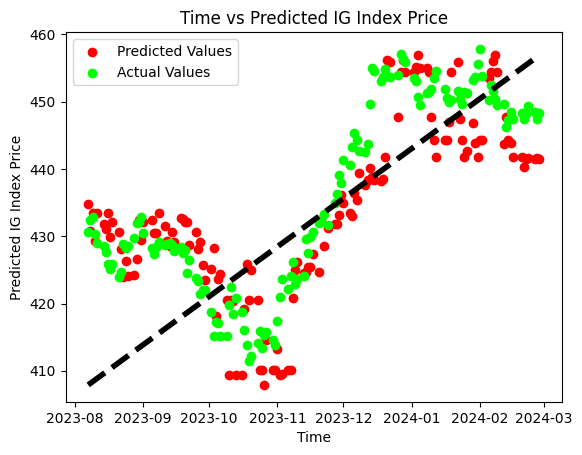

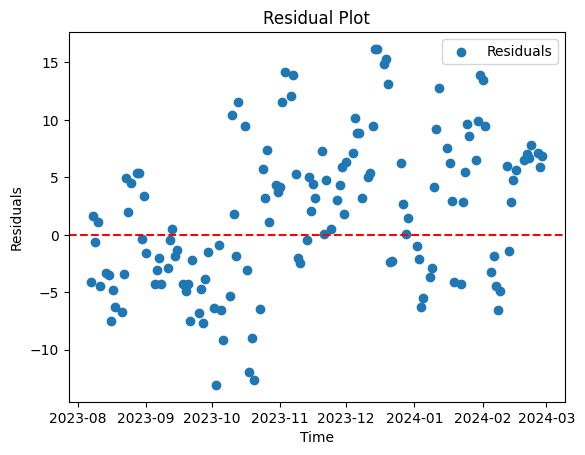

In [ ]:
# Time vs predicted IG values

plt.scatter(X_test_ig.index, y_pred_ig, c = ['#FF0000'], label='Predicted Values')
plt.scatter(X_test_ig.index, y_test_ig, c = ['#00FF00'], label='Actual Values')
plt.xlabel('Time')
plt.ylabel('Predicted IG Index Price')
plt.title('Time vs Predicted IG Index Price')
plt.plot([X_test_ig.index.min(), X_test_ig.index.max()], [y_pred_ig.min(), y_pred_ig.max()], 'k--', lw=4)
plt.legend()
plt.show()

# Create the residual plot
residuals = y_test_ig - y_pred_ig
plt.scatter(X_test_ig.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

In [ ]:
# Trying to predict IG index value with other features including momentum factor
features = ['SP500_Volume', 'S&P 500 Investment Grade Corporate Bond Index Lagged','1x0', '4x0', '12x0']

# for IG
target_ig = 'S&P 500 Investment Grade Corporate Bond Index'
X_ig = combined_data[features]
y_ig = combined_data[target_ig]
X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(X_ig, y_ig, test_size=0.2, shuffle=False)
rf_ig = RandomForestRegressor(random_state=42) # initialize regressor

# hyperparameter tuning using GridSearchCV
param_grid_ig = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
grid_search_ig = GridSearchCV(estimator=rf_ig, param_grid=param_grid_ig, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ig.fit(X_train_ig, y_train_ig)

# best parameters and score
best_params_ig = grid_search_ig.best_params_
best_score_ig = grid_search_ig.best_score_
print(f'Best Parameters for IG: {best_params_ig}')
print(f'Best Score for IG: {-best_score_ig}')

best_rf_ig = grid_search_ig.best_estimator_
y_pred_ig = best_rf_ig.predict(X_test_ig)
mse_ig = mean_squared_error(y_test_ig, y_pred_ig)
r2_ig = r2_score(y_test_ig, y_pred_ig)
print(f'IG Model - MSE: {mse_ig}, R2: {r2_ig}')


Best Parameters for IG: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for IG: 64.98479226971554
IG Model - MSE: 52.49299561246154, R2: 0.7248451488054444


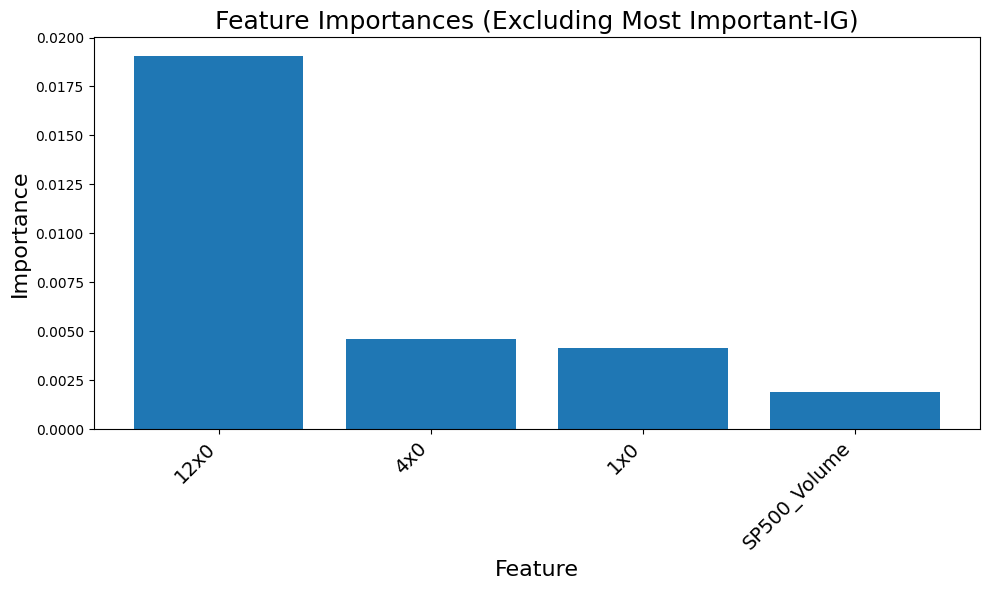

In [ ]:
# plot feature importance
feature_importances = best_rf_ig.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1][1:]  # Exclude the most important feature by slicing [1:]

# Create a bar chart for feature importances, excluding the most important feature
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Excluding Most Important-IG)", fontsize=18)
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), np.array(features)[sorted_indices], rotation=45, ha='right', fontsize=14)
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Importance', fontsize=16)
plt.tight_layout()
plt.show()

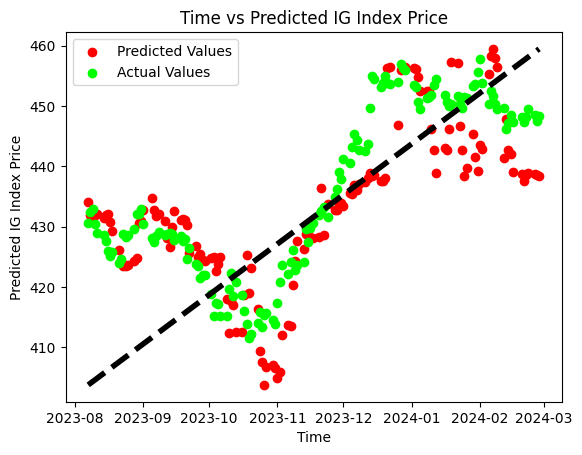

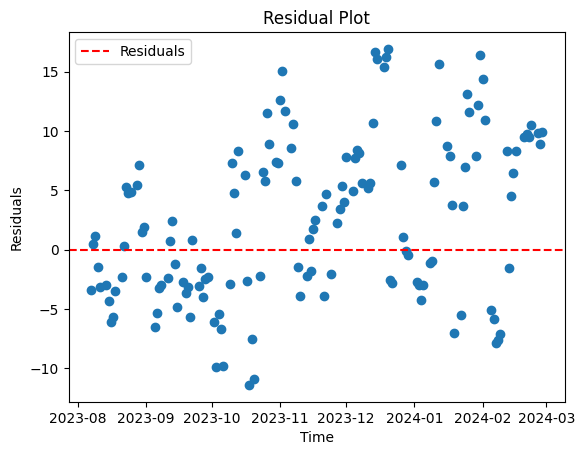

In [ ]:
# Time vs predicted IG values
plt.scatter(X_test_ig.index, y_pred_ig, c = ['#FF0000'], label='Predicted Values')
plt.scatter(X_test_ig.index, y_test_ig, c = ['#00FF00'], label='Actual Values')
plt.xlabel('Time')
plt.ylabel('Predicted IG Index Price')
plt.title('Time vs Predicted IG Index Price')
plt.plot([X_test_ig.index.min(), X_test_ig.index.max()], [y_pred_ig.min(), y_pred_ig.max()], 'k--', lw=4)
plt.legend()
plt.show()

# Create the residual plot
residuals = y_test_ig - y_pred_ig
plt.scatter(X_test_ig.index, residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

### HY

In [ ]:
features = ['S&P U.S. Dollar Global High Yield Corporate Bond Index Lagged']
target_hy = 'S&P U.S. Dollar Global High Yield Corporate Bond Index'
X_hy = combined_data[features]
y_hy = combined_data[target_hy]
X_train_hy, X_test_hy, y_train_hy, y_test_hy = train_test_split(X_hy, y_hy, test_size=0.2, random_state=42)

# hyperparameter tuning
grid_search_hy = GridSearchCV(estimator=rf_ig, param_grid=param_grid_ig, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_hy.fit(X_train_hy, y_train_hy)

best_params_hy = grid_search_hy.best_params_
best_score_hy = grid_search_hy.best_score_
print(f'Best Parameters for HY: {best_params_hy}')
print(f'Best Score for HY: {-best_score_hy}')

best_rf_hy = grid_search_hy.best_estimator_
y_pred_hy = best_rf_hy.predict(X_test_hy)
mse_hy = mean_squared_error(y_test_hy, y_pred_hy)
r2_hy = r2_score(y_test_hy, y_pred_hy)
print(f'HY Model - MSE: {mse_hy}, R2: {r2_hy}')


Best Parameters for HY: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Score for HY: 44.1327240599223
HY Model - MSE: 43.98859211576241, R2: 0.9690099779741616


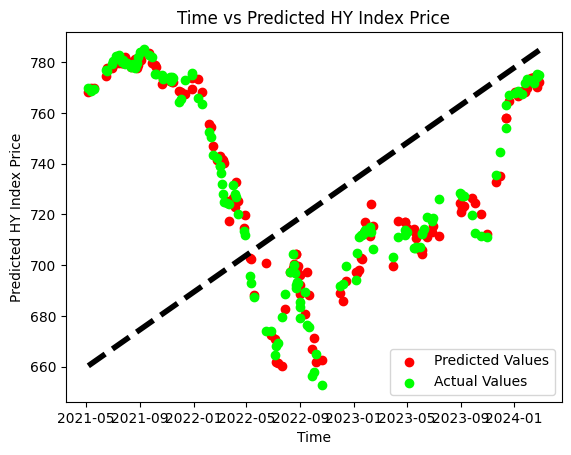

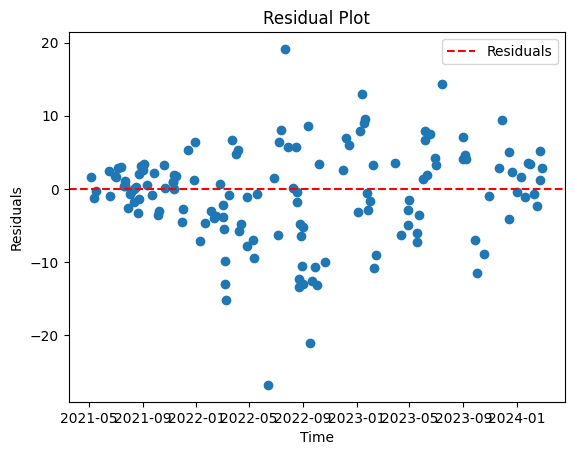

In [ ]:
# Time vs predicted HY values
plt.scatter(X_test_hy.index, y_pred_hy, c = ['#FF0000'], label='Predicted Values')
plt.scatter(X_test_hy.index, y_test_hy, c = ['#00FF00'], label='Actual Values')
plt.xlabel('Time')
plt.ylabel('Predicted HY Index Price')
plt.title('Time vs Predicted HY Index Price')
plt.plot([X_test_hy.index.min(), X_test_hy.index.max()], [y_pred_hy.min(), y_pred_hy.max()], 'k--', lw=4)
plt.legend()
plt.show()

# Create the residual plot
residuals = y_test_hy - y_pred_hy
plt.scatter(X_test_hy.index, residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

In [ ]:
# Trying to predict IG index value with other features including momentum factor
features = ['SP500_Volume', 'S&P U.S. Dollar Global High Yield Corporate Bond Index Lagged','1x0', '4x0', '12x0']
target_hy = 'S&P U.S. Dollar Global High Yield Corporate Bond Index'
X_hy = combined_data[features]
y_hy = combined_data[target_hy]
X_train_hy, X_test_hy, y_train_hy, y_test_hy = train_test_split(X_hy, y_hy, test_size=0.2, random_state=42)

# hyperparameter tuning
grid_search_hy = GridSearchCV(estimator=rf_ig, param_grid=param_grid_ig, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_hy.fit(X_train_hy, y_train_hy)

best_params_hy = grid_search_hy.best_params_
best_score_hy = grid_search_hy.best_score_
print(f'Best Parameters for HY: {best_params_hy}')
print(f'Best Score for HY: {-best_score_hy}')

best_rf_hy = grid_search_hy.best_estimator_
y_pred_hy = best_rf_hy.predict(X_test_hy)
mse_hy = mean_squared_error(y_test_hy, y_pred_hy)
r2_hy = r2_score(y_test_hy, y_pred_hy)
print(f'HY Model - MSE: {mse_hy}, R2: {r2_hy}')


Best Parameters for HY: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for HY: 14.077786848985976
HY Model - MSE: 14.945606668359616, R2: 0.9894708000969183


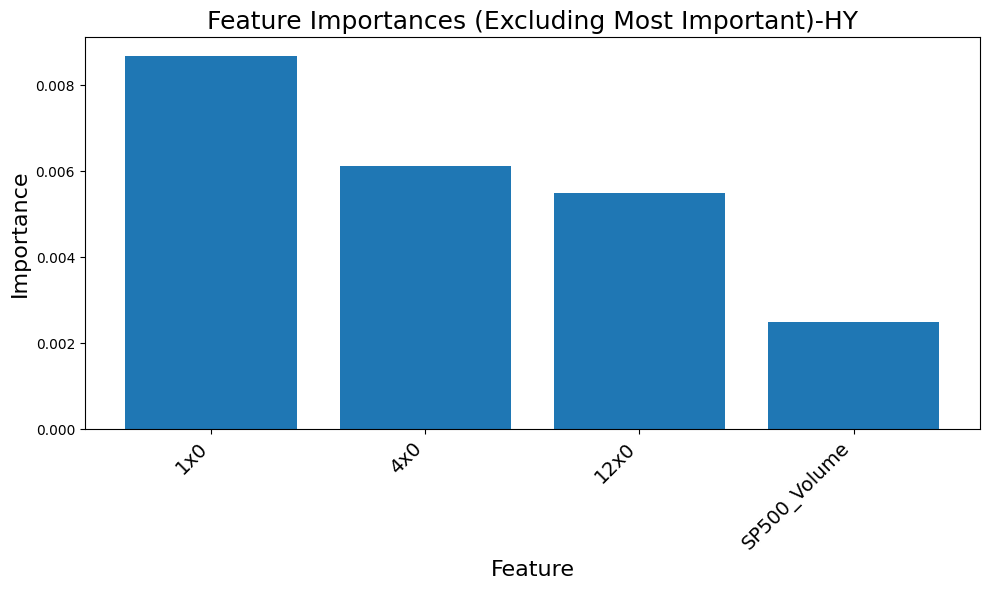

In [ ]:
# plot feature importance
feature_importances = best_rf_hy.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1][1:]  # Exclude the most important feature by slicing [1:]

# Create a bar chart for feature importances, excluding the most important feature
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Excluding Most Important)-HY", fontsize=18)
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), np.array(features)[sorted_indices], rotation=45, ha='right', fontsize=14)
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Importance', fontsize=16)
plt.tight_layout()
plt.show()

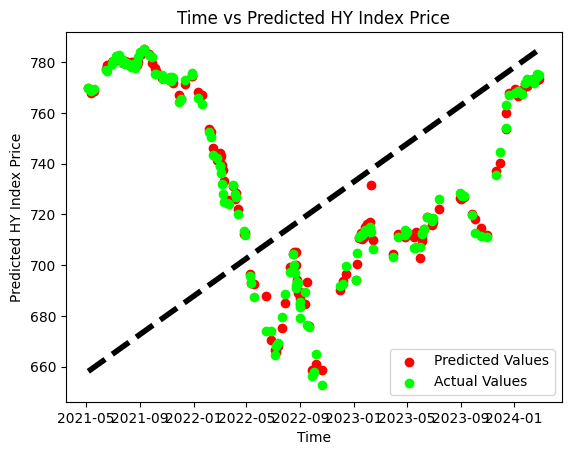

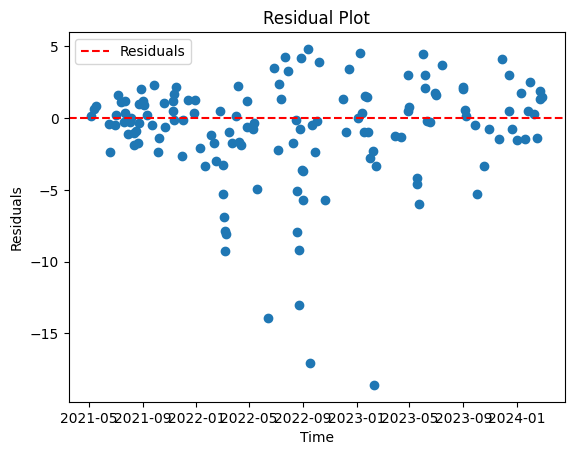

In [ ]:
# Time vs predicted HY values
plt.scatter(X_test_hy.index, y_pred_hy, c = ['#FF0000'], label='Predicted Values')
plt.scatter(X_test_hy.index, y_test_hy, c = ['#00FF00'], label='Actual Values')
plt.xlabel('Time')
plt.ylabel('Predicted HY Index Price')
plt.title('Time vs Predicted HY Index Price')
plt.plot([X_test_hy.index.min(), X_test_hy.index.max()], [y_pred_hy.min(), y_pred_hy.max()], 'k--', lw=4)
plt.legend()
plt.show()

# Create the residual plot
residuals = y_test_hy - y_pred_hy
plt.scatter(X_test_hy.index, residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

## Model Training-XGBoost

### IG

In [ ]:
xgb_reg_ig = xgb.XGBRegressor(objective='reg:squarederror', random_state=42) # initialize regressor
xgb_reg_ig.fit(X_train_ig, y_train_ig)
y_pred_xgb_ig = xgb_reg_ig.predict(X_test_ig)

mse_xgb_ig = mean_squared_error(y_test_ig, y_pred_xgb_ig)
r2_xgb_ig = r2_score(y_test_ig, y_pred_xgb_ig)
print(f'IG XGBoost Model - MSE: {mse_xgb_ig}, R2: {r2_xgb_ig}')

IG XGBoost Model - MSE: 40.80432761526979, R2: 0.786114155573013


### HY

In [ ]:
xgb_reg_hy = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg_hy.fit(X_train_hy, y_train_hy)
y_pred_xgb_hy = xgb_reg_hy.predict(X_test_hy)
mse_xgb_hy = mean_squared_error(y_test_hy, y_pred_xgb_hy)
r2_xgb_hy = r2_score(y_test_hy, y_pred_xgb_hy)
print(f'HY XGBoost Model - MSE: {mse_xgb_hy}, R2: {r2_xgb_hy}')

HY XGBoost Model - MSE: 20.826471510483604, R2: 0.9853277229438968


In [ ]:
# hyperparameter training for IG
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}
# grid search with cross-validation
grid_search_xgb_ig = GridSearchCV(estimator=xgb_reg_ig, param_grid=param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_ig.fit(X_train_ig, y_train_ig)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='r2')

In [ ]:
best_params_xgb_ig = grid_search_xgb_ig.best_params_
best_score_xgb_ig = grid_search_xgb_ig.best_score_
print(f"Best Hyperparameters for IG XGBoost Model: {best_params_xgb_ig}")
print(f"Best Cross-Validation R2 Score for IG: {best_score_xgb_ig}")

Best Hyperparameters for IG XGBoost Model: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation R2 Score for IG: 0.24645440154161866


In [ ]:
best_xgb_ig = grid_search_xgb_ig.best_estimator_
y_pred_xgb_ig = best_xgb_ig.predict(X_test_ig)

In [ ]:
mse_xgb_ig = mean_squared_error(y_test_ig, y_pred_xgb_ig)
r2_xgb_ig = r2_score(y_test_ig, y_pred_xgb_ig)
print(f"Tuned IG XGBoost Model - MSE: {mse_xgb_ig}, R2: {r2_xgb_ig}")

Tuned IG XGBoost Model - MSE: 40.5418370666991, R2: 0.7874900638630478


Random Forest - IG
MSE: 52.49299561246154, R2: 0.7248451488054444
XGBoost - IG
MSE: 40.5418370666991, R2: 0.7874900638630478


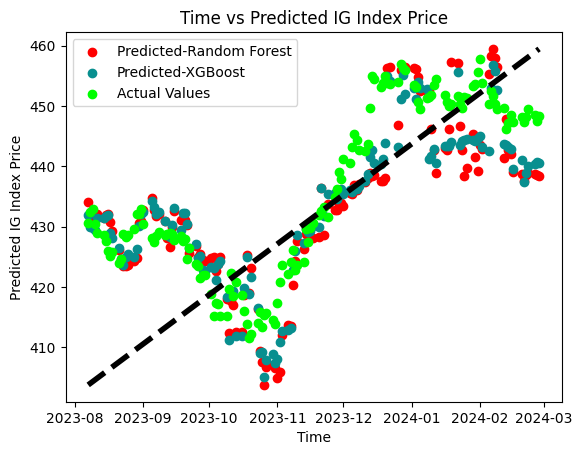

In [ ]:
# compare random forest and XGBoost for IG

# performance metrics
print("Random Forest - IG")
print(f"MSE: {mse_ig}, R2: {r2_ig}")
print("XGBoost - IG")
print(f"MSE: {mse_xgb_ig}, R2: {r2_xgb_ig}")

# Time vs predicted IG values

plt.scatter(X_test_ig.index, y_pred_ig, c = ['#FF0000'], label='Predicted-Random Forest') # prediction by Random Forest - Blue
plt.scatter(X_test_ig.index, y_pred_xgb_ig, c = ['#088F8F'], label='Predicted-XGBoost') # prediction by Xgboost - Red
plt.scatter(X_test_ig.index, y_test_ig, c = ['#00FF00'], label='Actual Values') # Green - True values
plt.xlabel('Time')
plt.ylabel('Predicted IG Index Price')
plt.title('Time vs Predicted IG Index Price')
plt.plot([X_test_ig.index.min(), X_test_ig.index.max()], [y_pred_ig.min(), y_pred_ig.max()], 'k--', lw=4)
plt.legend()
plt.show()

Random Forest - HY
MSE: 14.945606668359616, R2: 0.9894708000969183
XGBoost - HY
MSE: 20.826471510483604, R2: 0.9853277229438968


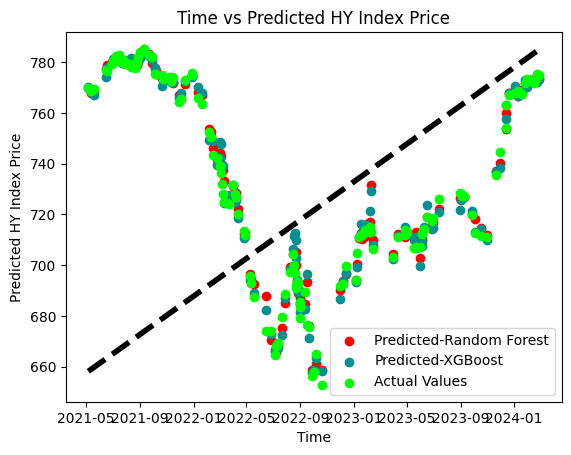

In [ ]:
# compare random forest and XGBoost for HY

# performance metrics
print("Random Forest - HY")
print(f"MSE: {mse_hy}, R2: {r2_hy}")
print("XGBoost - HY")
print(f"MSE: {mse_xgb_hy}, R2: {r2_xgb_hy}")

# Time vs predicted IG values

plt.scatter(X_test_hy.index, y_pred_hy, c = ['#FF0000'], label='Predicted-Random Forest') # prediction by Random Forest - Blue
plt.scatter(X_test_hy.index, y_pred_xgb_hy, c = ['#088F8F'], label='Predicted-XGBoost') # prediction by Xgboost - Red
plt.scatter(X_test_hy.index, y_test_hy, c = ['#00FF00'], label='Actual Values') # Green - True values
plt.xlabel('Time')
plt.ylabel('Predicted HY Index Price')
plt.title('Time vs Predicted HY Index Price')
plt.plot([X_test_hy.index.min(), X_test_hy.index.max()], [y_pred_hy.min(), y_pred_hy.max()], 'k--', lw=4)
plt.legend()
plt.show()

Neural Network based Regression

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from kerastuner import RandomSearch
from sklearn.metrics import mean_squared_error, r2_score
# IG
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.Dense(hp.Int('input_units', min_value=32, max_value=1024, step=32), activation='relu', input_shape=(X_train_ig.shape[1],)))

    # You can add more tunable layers if needed
    for i in range(hp.Int('n_layers', 1, 3)):  # Adding 1 to 3 tunable dense layers
        model.add(layers.Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32), activation='relu'))

    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of trials to run
    executions_per_trial=1,  # Number of models to build for each trial
    directory='my_dir',  # Directory to save the logs and models
    project_name='keras_tuning'
)

# Display search space summary
tuner.search_space_summary()

# Start the hyperparameter tuning process
tuner.search(X_train_ig, y_train_ig, epochs=10, validation_split=0.2, verbose=0)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_ig, y_train_ig, epochs=100, validation_split=0.2, verbose=0, shuffle=False)

# Predict on the test set
y_pred_nn_ig = model.predict(X_test_ig).flatten()

# Calculate metrics
mse_nn_ig = mean_squared_error(y_test_ig, y_pred_nn_ig)
r2_nn_ig = r2_score(y_test_ig, y_pred_nn_ig)
print(f'Optimized Neural Network Model - MSE: {mse_nn_ig}, R2: {r2_nn_ig}')


Reloading Tuner from my_dir/keras_tuning/tuner0.json
Search space summary
Default search space size: 5
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
5/5 [==============================] - 0s 5ms/step
Optimized Neural Network Model - MSE: 12349.723521771775, R2: -63.73409067781094


In [ ]:
# HY
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.Dense(hp.Int('input_units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_hy.shape[1],)))

    # You can add more tunable layers if needed
    for i in range(hp.Int('n_layers', 1, 3)):  # Adding 1 to 3 tunable dense layers
        model.add(layers.Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32), activation='relu'))

    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of trials to run
    executions_per_trial=1,  # Number of models to build for each trial
    directory='my_dir',  # Directory to save the logs and models
    project_name='keras_tuning'
)

# Display search space summary
tuner.search_space_summary()

# Start the hyperparameter tuning process
tuner.search(X_train_hy, y_train_hy, epochs=10, validation_split=0.2, verbose=0)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_hy, y_train_hy, epochs=100, validation_split=0.2, verbose=0, shuffle=False)

# Predict on the test set
y_pred_nn_hy = model.predict(X_test_hy).flatten()

# Calculate metrics
mse_nn_hy = mean_squared_error(y_test_hy, y_pred_nn_hy)
r2_nn_hy = r2_score(y_test_hy, y_pred_nn_hy)
print(f'Optimized Neural Network Model - MSE: {mse_nn_hy}, R2: {r2_nn_hy}')


Reloading Tuner from my_dir/keras_tuning/tuner0.json
Search space summary
Default search space size: 5
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
5/5 [==============================] - 0s 5ms/step
Optimized Neural Network Model - MSE: 26899.18832356634, R2: -17.95051417946591
